In [0]:
import os
import sys
import cv2 as cv
import numpy  as np
import pandas as pd
from glob import glob
from skimage import io
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow import keras
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras        import regularizers, optimizers
from tensorflow.keras.models import Sequential, Model, load_model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


***Loading RESNET50***

In [3]:
model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet')
model_ResNet50.summary()

W0819 17:09:07.241974 139647019333504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
def deep_feature(path, cinematica):
  X, y = [], []
  for folder_path in path:
    path_P1 = folder_path.strip().split(" ")[:2]
    path_P = '/content/gdrive/My Drive/PROYECT_HEART/DATASETS/SUNNYBROOK/'+cinematica+'/'+ path_P1[0] +"/"+path_P1[1]+"/"
    #print(path_P)
    folders_P1 = sorted(glob(os.path.join(path_P, '*.jpg')))
    #print(folders_P1)
    for images in folders_P1:
        img = tf.contrib.keras.preprocessing.image.load_img(images, target_size=(224, 224))
        img = tf.contrib.keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0);
        descriptor = model_fc_Resnet.predict(img)
        #print(descriptor.shape)
        descriptor = descriptor.flatten()
        X.append(descriptor)
        y.append(path_P1[0][0])
  return np.array(X), np.array(y)

In [0]:
first = ['0-HF-I-01 7','0-HF-I-02 3','0-HF-I-05 7','0-HF-I-06 4','0-HF-I-07 4','0-HF-I-08 3','0-HF-I-09 9','0-HF-I-10 9','0-HF-I-11 3','0-HF-I-12 2','0-HF-I-40 4',
         '1-HF-NI-03 3','1-HF-NI-04 2','1-HF-NI-07 3','1-HF-NI-11 8','1-HF-NI-12 4','1-HF-NI-13 8','1-HF-NI-14 8','1-HF-NI-15 6','1-HF-NI-31 6','1-HF-NI-33 3','1-HF-NI-34 8','1-HF-NI-36 6',
         '2-HYP-01 4','2-HYP-03 3','2-HYP-06 6','2-HYP-07 7','2-HYP-08 5','2-HYP-09 8','2-HYP-10 2','2-HYP-11 8','2-HYP-12 3','2-HYP-37 7','2-HYP-38 3','2-HYP-40 5',
         '3-N-02 6','3-N-03 9','3-N-05 3','3-N-06 6','3-N-07 9','3-N-09 7','3-N-10 8','3-N-11 2','3-N-40 8']
model_fc_Resnet = tf.keras.models.Model(inputs=model_ResNet50.input,outputs=model_ResNet50.get_layer('res2a_branch2a').output)

In [0]:
X, y = deep_feature(first, 'SB_PPM')
print("Número de pacientes:  ", X.shape)
print("Número de clases:     ", int(np.unique(y)[-1])+1)

Número de pacientes:   (880, 200704)
Número de clases:      4


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Valores train y test: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Valores train y test:  (616, 200704) (264, 200704) (616,) (264,)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy RF 1.0


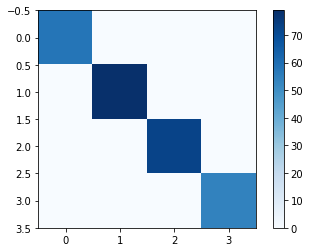

In [0]:
RF =  RandomForestClassifier()
RF.fit(X_train, y_train)
rf_pred = RF.predict(X_test)
print("Accuracy RF", RF.score(X_test, y_test))

cm_RF = confusion_matrix(y_test, rf_pred)
plt.imshow(cm_RF, interpolation="nearest", cmap=plt.cm.Blues), plt.colorbar();
plt.title('Heart - RF')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy SVM 1.0


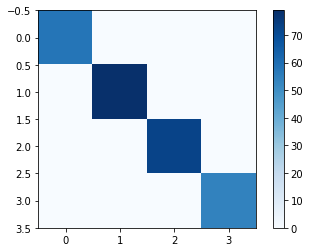

In [0]:
SVM =  SVC()
SVM.fit(X_train, y_train)
SVM_pred = SVM.predict(X_test)
print("Accuracy SVM", SVM.score(X_test, y_test))

cm_SVM = confusion_matrix(y_test, SVM_pred)
plt.imshow(cm_SVM, interpolation="nearest", cmap=plt.cm.Blues), plt.colorbar();
plt.title('Heart - SVM')

In [16]:
inputs = Input(200704)
dense = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
dense = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense)
output = Dense(4, activation='softmax')(dense)
model = Model(inputs = [inputs], outputs = [output], name='Convolutional3D')

model.summary()

Model: "Convolutional3D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200704)]          0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               102760960 
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1028      
Total params: 102,893,316
Trainable params: 102,893,316
Non-trainable params: 0
_________________________________________________________________


In [0]:
sgd = optimizers.SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=15, verbose=1, validation_data=(X_test, y_test))

Train on 616 samples, validate on 264 samples
Epoch 1/15
616/616 [==============================] - 20s 33ms/sample - loss: 5.6373 - acc: 0.2841 - val_loss: 4.4639 - val_acc: 0.2992
Epoch 2/15
616/616 [==============================] - 15s 25ms/sample - loss: 4.0471 - acc: 0.3084 - val_loss: 4.8785 - val_acc: 0.2538
Epoch 3/15
616/616 [==============================] - 15s 25ms/sample - loss: 3.2358 - acc: 0.3880 - val_loss: 2.8648 - val_acc: 0.4394
Epoch 4/15
616/616 [==============================] - 15s 25ms/sample - loss: 2.6799 - acc: 0.4984 - val_loss: 2.7572 - val_acc: 0.3220
Epoch 5/15
616/616 [==============================] - 15s 25ms/sample - loss: 2.4405 - acc: 0.5471 - val_loss: 2.0671 - val_acc: 0.8106
Epoch 6/15
616/616 [==============================] - 16s 26ms/sample - loss: 2.1404 - acc: 0.6607 - val_loss: 1.9449 - val_acc: 0.7235
Epoch 7/15
616/616 [==============================] - 15s 25ms/sample - loss: 1.9383 - acc: 0.7435 - val_loss: 1.7200 - val_acc: 0.8598
Ep

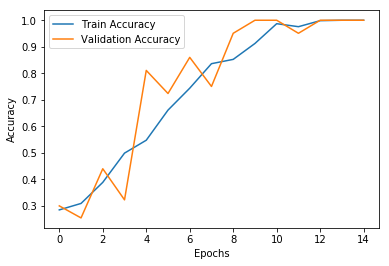

In [0]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

***Flujo óptico***

In [34]:
X_of, y_of = deep_feature(first, 'SB_OF')
print("Número de pacientes:  ", X_of.shape)
print("Número de clases:     ", int(np.unique(y_of)[-1])+1)

Número de pacientes:   (865, 200704)
Número de clases:      4


In [35]:
X_train_OF, X_test_OF, y_train_OF, y_test_OF = train_test_split(X_of, y_of, test_size=0.3)
print("Valores train y test: ", X_train_OF.shape, X_test_OF.shape, y_train_OF.shape, y_test_OF.shape)

Valores train y test:  (605, 200704) (260, 200704) (605,) (260,)


In [0]:
RF_TRAIN, RF_TEST, SCORES = [], [], []
for i in np.arange(1,100,10):
  
  RF_OF =  RandomForestClassifier(n_estimators=i)
  RF_OF.fit(X_train_OF, y_train_OF)
  rf_pred_OF = RF_OF.predict(X_test_OF)
  RF_TEST.append(rf_pred_OF)
  RF_TRAIN.append(RF_OF.predict(X_train_OF))
  SCORES.append(RF_OF.score(X_test_OF, y_test_OF))

Accuracy RF 0.7884615384615384


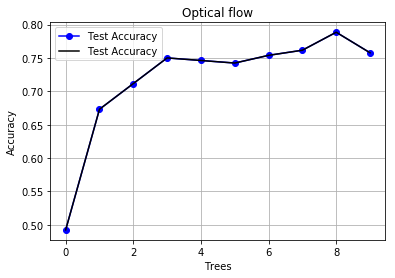

In [67]:
print("Accuracy RF", np.max(np.array(SCORES)))
plt.plot(SCORES, 'bo-', SCORES, 'k', label='Test Accuracy')
plt.title('Optical flow')
plt.xlabel('Trees')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Optical flow - RF')

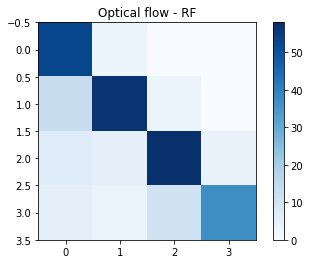

In [68]:
cm_RF_OF = confusion_matrix(y_test_OF, RF_TEST[8])
plt.imshow(cm_RF_OF, interpolation="nearest", cmap=plt.cm.Blues), plt.colorbar();
plt.title('Optical flow - RF')

Accuracy SVM 0.7346153846153847


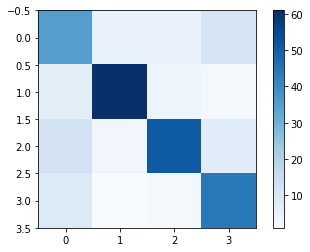

In [52]:
SVM_OF =  SVC(kernel='linear')
SVM_OF.fit(X_train_OF, y_train_OF)
SVM_pred_OF = SVM_OF.predict(X_test_OF)
print("Accuracy SVM", SVM_OF.score(X_test_OF, y_test_OF))

cm_SVM_OF = confusion_matrix(y_test_OF, SVM_pred_OF)
plt.imshow(cm_SVM_OF, interpolation="nearest", cmap=plt.cm.Blues), plt.colorbar();

In [0]:
sgd = optimizers.SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
history_OF = model.fit(X_train_OF, y_train_OF, batch_size=64, epochs=15, verbose=1, validation_data=(X_test_OF, y_test_OF))

W0818 21:38:36.902132 140402861270912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 605 samples, validate on 260 samples
Epoch 1/15
605/605 [==============================] - 5s 9ms/sample - loss: 5.1729 - acc: 0.2198 - val_loss: 3.9182 - val_acc: 0.3038
Epoch 2/15
605/605 [==============================] - 1s 2ms/sample - loss: 4.0210 - acc: 0.2397 - val_loss: 3.4568 - val_acc: 0.3038
Epoch 3/15
605/605 [==============================] - 1s 2ms/sample - loss: 3.3155 - acc: 0.2711 - val_loss: 3.6579 - val_acc: 0.2923
Epoch 4/15
605/605 [==============================] - 1s 2ms/sample - loss: 3.1701 - acc: 0.2413 - val_loss: 3.0090 - val_acc: 0.2923
Epoch 5/15
605/605 [==============================] - 1s 2ms/sample - loss: 3.0509 - acc: 0.2248 - val_loss: 2.7538 - val_acc: 0.1731
Epoch 6/15
605/605 [==============================] - 1s 2ms/sample - loss: 3.0145 - acc: 0.2678 - val_loss: 3.1150 - val_acc: 0.1731
Epoch 7/15
605/605 [==============================] - 1s 2ms/sample - loss: 2.9263 - acc: 0.2793 - val_loss: 2.7450 - val_acc: 0.2923
Epoch 8/15
605/6

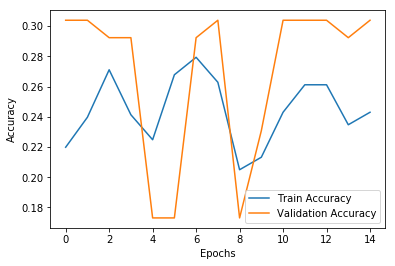

In [0]:
plt.plot(history_OF.history['acc'], label='Train Accuracy')
plt.plot(history_OF.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

***Aceleración normal***

In [7]:
X_an, y_an = deep_feature(first, 'SB_AN')
print("Número de pacientes:  ", X_an.shape)
print("Número de clases:     ", int(np.unique(y_an)[-1])+1)

W0819 17:09:22.287557 139647019333504 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Número de pacientes:   (836, 200704)
Número de clases:      4


In [8]:
X_train_AN, X_test_AN, y_train_AN, y_test_AN = train_test_split(X_an, y_an, test_size=0.3)
print("Valores train y test: ", X_train_AN.shape, X_test_AN.shape, y_train_AN.shape, y_test_AN.shape)

Valores train y test:  (585, 200704) (251, 200704) (585,) (251,)


In [0]:
RF_TRAIN_AN, RF_TEST_AN, SCORES_AN = [], [], []
for i in np.arange(1,100,10):
  
  RF_AN =  RandomForestClassifier(n_estimators=i)
  RF_AN.fit(X_train_AN, y_train_AN)
  rf_pred_AN = RF_AN.predict(X_test_AN)
  RF_TEST_AN.append(rf_pred_AN)
  RF_TRAIN_AN.append(RF_AN.predict(X_train_AN))
  SCORES_AN.append(RF_AN.score(X_test_AN, y_test_AN))

Accuracy RF 0.7529880478087649


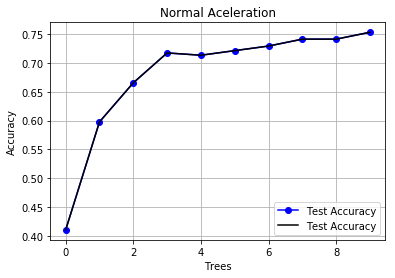

In [53]:
print("Accuracy RF", np.max(np.array(SCORES_AN)))
plt.plot(SCORES_AN, 'bo-',SCORES_AN, 'k', label='Test Accuracy')
plt.title('Normal Aceleration')
plt.xlabel('Trees')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Normal Aceleration - RF')

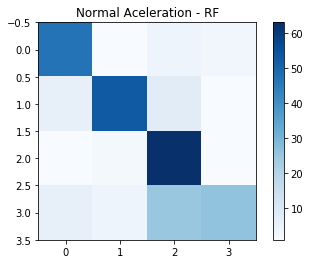

In [55]:
cm_RF_AN = confusion_matrix(y_test_AN, RF_TEST_AN[9])
plt.imshow(cm_RF_AN, interpolation="nearest", cmap=plt.cm.Blues), plt.colorbar();
plt.title('Normal Aceleration - RF')

Accuracy SVM 0.7171314741035857


Text(0.5, 1.0, 'Normal Aceleration - SVM')

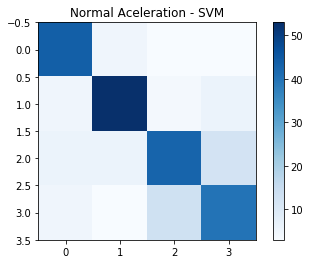

In [59]:
SVM_AN =  SVC(kernel='linear')
SVM_AN.fit(X_train_AN, y_train_AN)
SVM_pred_AN = SVM_AN.predict(X_test_AN)
print("Accuracy SVM", SVM_AN.score(X_test_AN, y_test_AN))

cm_SVM_AN = confusion_matrix(y_test_AN, SVM_pred_AN)
plt.imshow(cm_SVM_AN, interpolation="nearest", cmap=plt.cm.Blues), plt.colorbar();
plt.title('Normal Aceleration - SVM')

In [17]:
sgd = optimizers.SGD(lr=0.001, decay=0, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
history_AN = model.fit(X_train_AN, y_train_AN, batch_size=64, epochs=50, verbose=1, validation_data=(X_test_AN, y_test_AN))

Train on 585 samples, validate on 251 samples
Epoch 1/50
585/585 [==============================] - 5s 8ms/sample - loss: 2.9826 - acc: 0.2427 - val_loss: 3.1298 - val_acc: 0.2510
Epoch 2/50
585/585 [==============================] - 2s 3ms/sample - loss: 2.8168 - acc: 0.3009 - val_loss: 2.7209 - val_acc: 0.3147
Epoch 3/50
585/585 [==============================] - 2s 3ms/sample - loss: 2.7098 - acc: 0.3299 - val_loss: 2.8277 - val_acc: 0.2709
Epoch 4/50
585/585 [==============================] - 2s 3ms/sample - loss: 2.7207 - acc: 0.3248 - val_loss: 3.2504 - val_acc: 0.2550
Epoch 5/50
585/585 [==============================] - 2s 3ms/sample - loss: 2.7430 - acc: 0.3504 - val_loss: 2.9398 - val_acc: 0.2590
Epoch 6/50
585/585 [==============================] - 2s 3ms/sample - loss: 2.7189 - acc: 0.3453 - val_loss: 2.9337 - val_acc: 0.3028
Epoch 7/50
585/585 [==============================] - 2s 3ms/sample - loss: 2.6815 - acc: 0.3590 - val_loss: 2.6953 - val_acc: 0.3267
Epoch 8/50
585/5

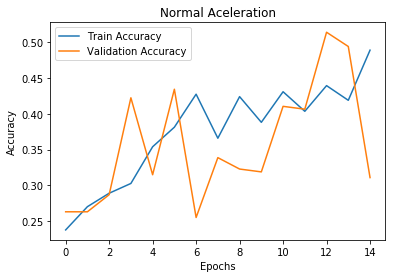

In [15]:
plt.plot(history_AN.history['acc'], label='Train Accuracy')
plt.plot(history_AN.history['val_acc'], label='Validation Accuracy')
plt.title('Normal Aceleration')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()